This is fifth part of https://www.kaggle.com/mustafacicek/detailed-marketing-cohort-pareto-rfm-forecast/

You can reach this data from here. https://www.kaggle.com/mustafacicek/online-retail-final

Now, I will perform time series analysis on daily data for online retail dataset.

Before I start, I just want to point out, my goal is not create a best model for this dataset. I aim to basic introduction to Prophet, and diversify the context of my work on Online Retail dataset. I hope you'll enjoy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet
from sklearn.metrics import r2_score, mean_squared_error

np.random.seed(666)

# Data Preparation for Time Series

In [2]:
df = pd.read_csv("../input/online-retail-final/online_retail_final.csv")
display(df.head())

print(df.shape)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


(392735, 9)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392735 entries, 0 to 392734
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    392735 non-null  int64  
 1   StockCode    392735 non-null  object 
 2   Description  392735 non-null  object 
 3   Quantity     392735 non-null  int64  
 4   InvoiceDate  392735 non-null  object 
 5   UnitPrice    392735 non-null  float64
 6   CustomerID   392735 non-null  float64
 7   Country      392735 non-null  object 
 8   TotalPrice   392735 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 27.0+ MB


I will use only UK sales for this analysis.

In [4]:
df = df[df.Country == "United Kingdom"]

In [5]:
df.loc[:, "InvoiceDate"] = pd.to_datetime(df.loc[:, "InvoiceDate"])

print(f"First observation on data is {df.InvoiceDate.min()}")
print(f"Last observation on data is {df.InvoiceDate.max()}")

print(f"We have {(df.InvoiceDate.max() - df.InvoiceDate.min()).days} days.")

First observation on data is 2010-12-01 08:26:00
Last observation on data is 2011-12-09 12:49:00
We have 373 days.


We have 373 days sales record. Daily data can be more suitable.

In [6]:
df.set_index("InvoiceDate", inplace = True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,TotalPrice
InvoiceDate,,,,,,,,
2010-12-01 08:26:00,536365,85123A,white hanging heart t-light holder,6,2.55,17850.0,United Kingdom,15.30
2010-12-01 08:26:00,536365,71053,white metal lantern,6,3.39,17850.0,United Kingdom,20.34
2010-12-01 08:26:00,536365,84406B,cream cupid hearts coat hanger,8,2.75,17850.0,United Kingdom,22.00
2010-12-01 08:26:00,536365,84029G,knitted union flag hot water bottle,6,3.39,17850.0,United Kingdom,20.34
2010-12-01 08:26:00,536365,84029E,red woolly hottie white heart.,6,3.39,17850.0,United Kingdom,20.34


# Weekly

In [7]:
prices_df = pd.DataFrame(df.groupby("InvoiceDate").TotalPrice.sum())
prices_df = prices_df.iloc[:-1]
prices_df

,TotalPrice
InvoiceDate,
2010-12-01 08:26:00,139.12
2010-12-01 08:28:00,22.20
2010-12-01 08:34:00,348.78
2010-12-01 08:35:00,17.85
2010-12-01 09:00:00,204.00
...,...
2011-12-09 12:20:00,145.29
2011-12-09 12:21:00,29.88
2011-12-09 12:23:00,124.60


In [8]:
weekly_prices = prices_df.resample("W").sum()
weekly_prices.head()

,TotalPrice
InvoiceDate,
2010-12-05,118082.07
2010-12-12,145153.96
2010-12-19,127871.19
2010-12-26,27718.88
2011-01-02,0.00


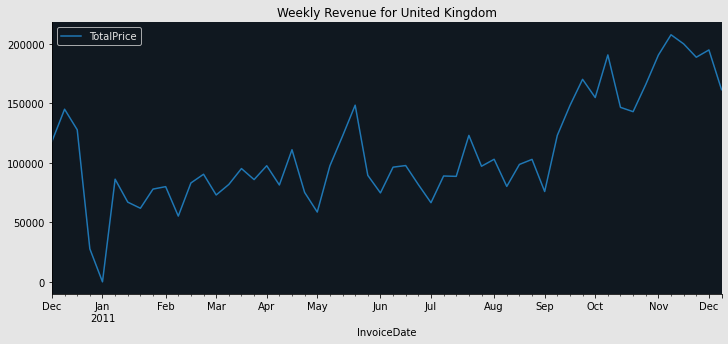

In [9]:
fig, ax = plt.subplots(figsize = (12, 5), facecolor = "#e5e5e5")
ax.set_facecolor("#101820")

weekly_prices.plot(ax = ax).set_title("Weekly Revenue for United Kingdom")
ax.legend(facecolor = "#101820", labelcolor = "#e5e5e5")

sns.despine()
plt.show()

Here, we have revenue per week graph. Let's interpret it.

Earlier January, this retailer was closed. Revenue is 0.

We see first peak in the middle of May.

Second peak is in the beginning of October.

Then the revenue top out in the middle of November.

# Daily Data

I just convert data to daily form with using resample method. Let's dive in.

In [10]:
daily_sales = pd.DataFrame(df.groupby("InvoiceDate").sum().resample("D").sum()["TotalPrice"])
daily_sales

,TotalPrice
InvoiceDate,
2010-12-01,34662.95
2010-12-02,40698.98
2010-12-03,17916.64
2010-12-04,0.00
2010-12-05,24803.50
...,...
2011-12-05,45548.33
2011-12-06,38424.19
2011-12-07,31102.15


We saw that there is a zero revenue week in earlier January.

In [11]:
daily_sales.loc["2010-12-23" : "2011-1-4"]

,TotalPrice
InvoiceDate,
2010-12-23,3963.97
2010-12-24,0.00
2010-12-25,0.00
2010-12-26,0.00
2010-12-27,0.00
2010-12-28,0.00
2010-12-29,0.00
2010-12-30,0.00
2010-12-31,0.00


In [12]:
daily_sales.reset_index(inplace = True)
daily_sales["Closed"] = np.where((daily_sales.TotalPrice == 0), 1, 0)
daily_sales.set_index("InvoiceDate", inplace = True)

In [13]:
daily_sales["weekday"] = daily_sales.index.day_name()
daily_sales

,TotalPrice,Closed,weekday
InvoiceDate,,,
2010-12-01,34662.95,0,Wednesday
2010-12-02,40698.98,0,Thursday
2010-12-03,17916.64,0,Friday
2010-12-04,0.00,1,Saturday
2010-12-05,24803.50,0,Sunday
...,...,...,...
2011-12-05,45548.33,0,Monday
2011-12-06,38424.19,0,Tuesday
2011-12-07,31102.15,0,Wednesday


In [14]:
daily_sales[daily_sales.TotalPrice == 0].weekday.value_counts()

Saturday     53
Monday        6
Friday        4
Sunday        3
Tuesday       1
Wednesday     1
Thursday      1
Name: weekday, dtype: int64

Okey, we don't have any record at 69 days. 53 of 69 is saturday. This retailer could be closed on saturdays. Let's look at total revenues per weekday.

In [15]:
daily_sales.groupby("weekday").TotalPrice.sum()

weekday
Friday        863095.82
Monday        951880.49
Saturday           0.00
Sunday        670059.45
Thursday     1267947.65
Tuesday      1049568.92
Wednesday    1100971.37
Name: TotalPrice, dtype: float64

Yeap, this retailer closed on saturdays.

In [16]:
daily_sales_workdays = daily_sales[daily_sales.TotalPrice > 0].copy()
daily_sales.drop("weekday", axis = 1, inplace = True)
daily_sales_workdays.drop("weekday", axis = 1, inplace = True)

# Stationarity

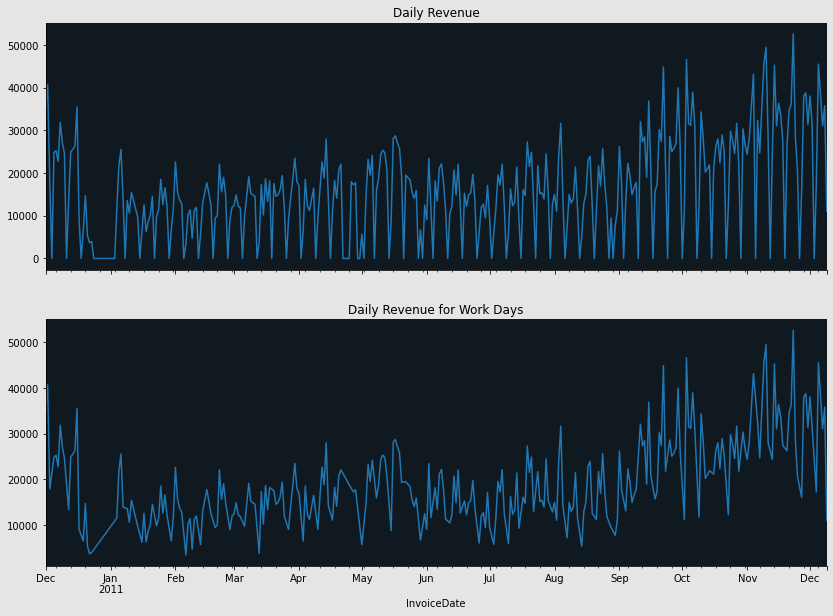

In [17]:
fig, axes = plt.subplots(2, 1, sharex = True, figsize = (14, 10), facecolor = "#e5e5e5")

for ax in axes: ax.set_facecolor("#101820")

daily_sales.TotalPrice.plot(ax = axes[0]).set_title("Daily Revenue")
daily_sales_workdays.TotalPrice.plot(ax = axes[1]).set_title("Daily Revenue for Work Days")

sns.despine()
plt.show()

As we can see above daily revenue graphs, we have an increasing trend for end of the year.

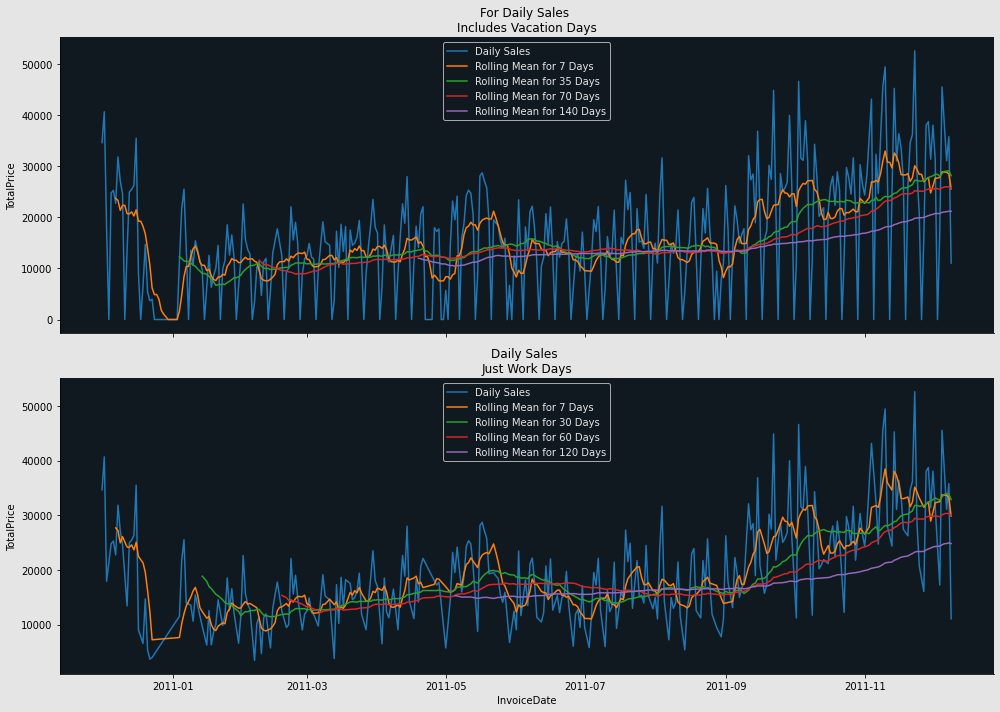

In [18]:
fig, axes = plt.subplots(2, 1, sharex = True, figsize = (14, 10), facecolor = "#e5e5e5")

for ax in axes: ax.set_facecolor("#101820")
    
sns.lineplot(x = daily_sales.index, y = daily_sales.TotalPrice, 
             ax = axes[0], label = "Daily Sales").set_title("For Daily Sales \nIncludes Vacation Days")

sns.lineplot(x = daily_sales.index, y = daily_sales.TotalPrice.rolling(7).mean(), 
             ax = axes[0], label = "Rolling Mean for 7 Days")
sns.lineplot(x = daily_sales.index, y = daily_sales.TotalPrice.rolling(35).mean(), 
             ax = axes[0], label = "Rolling Mean for 35 Days")
sns.lineplot(x = daily_sales.index, y = daily_sales.TotalPrice.rolling(70).mean(), 
             ax = axes[0], label = "Rolling Mean for 70 Days")
sns.lineplot(x = daily_sales.index, y = daily_sales.TotalPrice.rolling(140).mean(), 
             ax = axes[0], label = "Rolling Mean for 140 Days")


sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice, 
             ax = axes[1], label = "Daily Sales").set_title("Daily Sales \nJust Work Days")

sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.rolling(6).mean(), 
             ax = axes[1], label = "Rolling Mean for 7 Days")
sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.rolling(30).mean(),
             ax = axes[1], label = "Rolling Mean for 30 Days")
sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.rolling(60).mean(), 
             ax = axes[1], label = "Rolling Mean for 60 Days")
sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.rolling(120).mean(), 
             ax = axes[1], label = "Rolling Mean for 120 Days")

for ax in axes: ax.legend(facecolor = "#101820", labelcolor = "#e5e5e5")
    
sns.despine()
plt.tight_layout()
plt.show()

Let's check stationarity. Stationarity simply means that, our series has constant mean, variance on different times.

In above rolling mean plots, we saw that our mean values increase over time.

But, let's check it with Augmented Dickey Fuller test.

# Augmented Dickey-Fuller Test

In [19]:
def check_adf(series, check = 0.05):
    
    adf = adfuller(series, autolag = "AIC")
    
    print(f"H0: {series.name} is non-stationary.")
    print(f"H1: {series.name} is stationary.\n")
    
    test_stat = adf[0]; print(f"ADF test statistic: {adf[0]}")
    pvalue = adf[1]; print(f"p-value: {adf[1]}")
    print(f"Number of lags: {adf[2]}")    
    print("\nCritical Values : \n")
    for key, item in adf[4].items(): print("\t", key, "\t", item)
    
    print(f"\nFor {check} significance level: \n")
    if pvalue < check:
        print("We can reject null hypothesis. This series is stationary.")
    else:
        print("We can not reject null hypothesis. This series is non-stationary.")

In [20]:
print("Performing Augmented Dickey-Fuller test for Total Price \n")

check_adf(daily_sales.TotalPrice)

print("\nPerforming Augmented Dickey-Fuller test for Total Price (for workdays)\n")

check_adf(daily_sales_workdays.TotalPrice)

Performing Augmented Dickey-Fuller test for Total Price 

H0: TotalPrice is non-stationary.
H1: TotalPrice is stationary.

ADF test statistic: -2.37144204157222
p-value: 0.14995941633236576
Number of lags: 16

Critical Values : 

	 1% 	 -3.44880082033912
	 5% 	 -2.869670179576637
	 10% 	 -2.5711012838861036

For 0.05 significance level: 

We can not reject null hypothesis. This series is non-stationary.

Performing Augmented Dickey-Fuller test for Total Price (for workdays)

H0: TotalPrice is non-stationary.
H1: TotalPrice is stationary.

ADF test statistic: -1.6611112579837541
p-value: 0.4512522148978491
Number of lags: 13

Critical Values : 

	 1% 	 -3.4530232710482367
	 5% 	 -2.871523926671883
	 10% 	 -2.5720897694878424

For 0.05 significance level: 

We can not reject null hypothesis. This series is non-stationary.


For ADF test, this series is not stationary. To make it stationary, we have two main option.

1- Take difference until it become stationary.

2- Apply transformations: Log, square root, etc.

We can take difference with using .diff() method.

In this problem, our series has seasonal behaivor. Our revenue is increasing from saturday to thursday, then it decrease. For taking difference of seasonal series, we need set period in diff method.

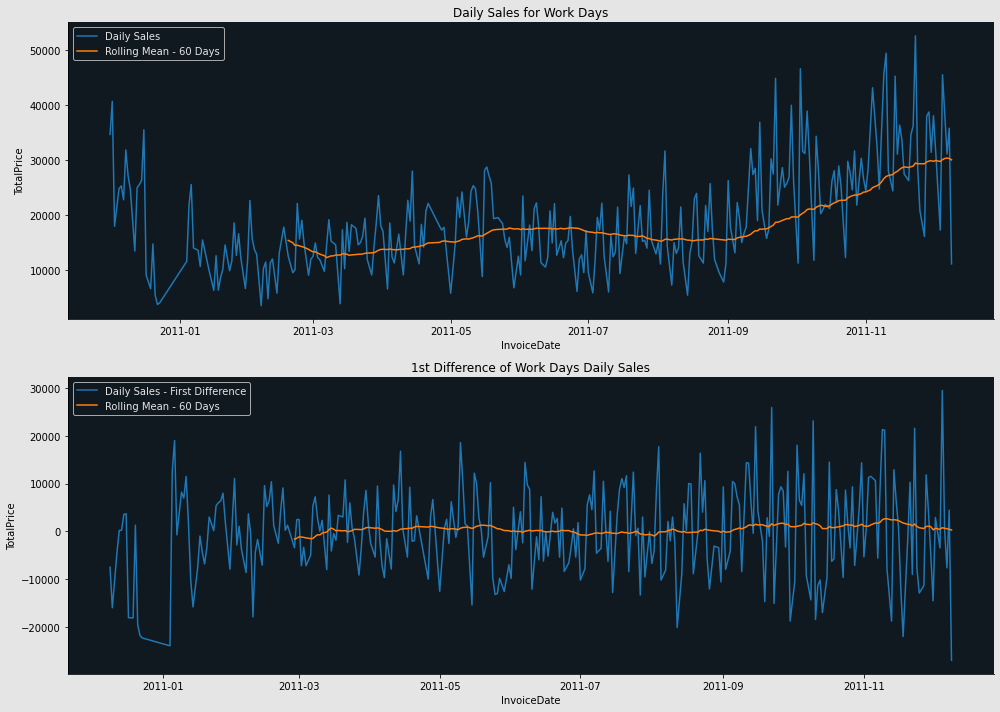

In [21]:
fig, axes = plt.subplots(2, 1, figsize = (14, 10), facecolor = "#e5e5e5")

for ax in axes: ax.set_facecolor("#101820")

sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice, 
             ax = axes[0], label = "Daily Sales").set_title("Daily Sales for Work Days")
sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.rolling(60).mean(), 
             ax = axes[0], label = "Rolling Mean - 60 Days")

sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.diff(7), 
             ax = axes[1], label = "Daily Sales - First Difference").set_title("1st Difference of Work Days Daily Sales")
sns.lineplot(x = daily_sales_workdays.index, y = daily_sales_workdays.TotalPrice.diff(7).rolling(60).mean(), 
             ax = axes[1], label = "Rolling Mean - 60 Days")

for ax in axes: ax.legend(facecolor = "#101820", labelcolor = "#e5e5e5")

sns.despine()
plt.tight_layout()
plt.show()

Nice, we have a constant mean over time. Let's look at ADF test results of 1st differenced series.

In [22]:
print("Performing Augmented Dickey-Fuller test for 1st Difference Revenue (All Days)")
check_adf(daily_sales["TotalPrice"].diff(7).dropna())

print("\nPerforming Augmented Dickey-Fuller test for 1st Difference of Work Days Sales")
check_adf(daily_sales_workdays["TotalPrice"].diff(6).dropna())

Performing Augmented Dickey-Fuller test for 1st Difference Revenue (All Days)
H0: TotalPrice is non-stationary.
H1: TotalPrice is stationary.

ADF test statistic: -7.211241124675088
p-value: 2.2319745316402812e-10
Number of lags: 13

Critical Values : 

	 1% 	 -3.4490114443793214
	 5% 	 -2.8697627072503757
	 10% 	 -2.5711506161673716

For 0.05 significance level: 

We can reject null hypothesis. This series is stationary.

Performing Augmented Dickey-Fuller test for 1st Difference of Work Days Sales
H0: TotalPrice is non-stationary.
H1: TotalPrice is stationary.

ADF test statistic: -6.34512613312661
p-value: 2.6946747449941925e-08
Number of lags: 11

Critical Values : 

	 1% 	 -3.453342167806272
	 5% 	 -2.871663828287282
	 10% 	 -2.572164381381345

For 0.05 significance level: 

We can reject null hypothesis. This series is stationary.


We make the series stationary. Let's decompose and examine its components.

# Seasonality, Decomposition

In [23]:
decompose = seasonal_decompose(daily_sales["TotalPrice"], period = 7)

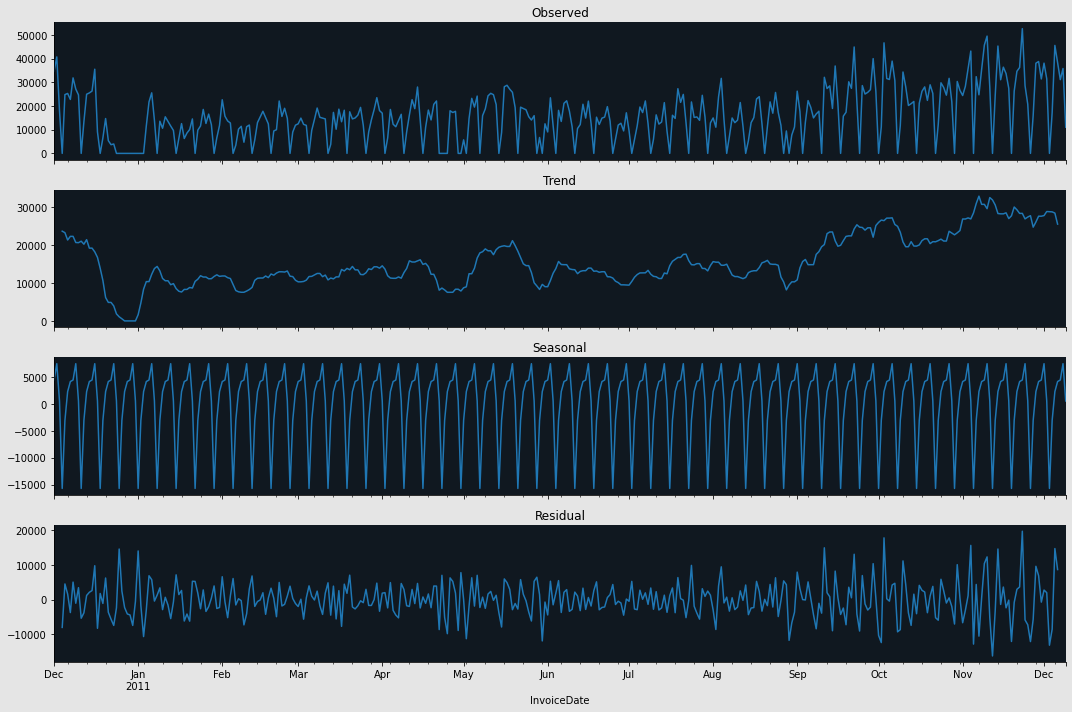

In [24]:
fig, axes = plt.subplots(4, 1, sharex = True, figsize = (15, 10), facecolor = "#e5e5e5")

for ax in axes: ax.set_facecolor("#101820")

decompose.observed.plot(ax = axes[0]).set_title("Observed")
decompose.trend.plot(ax = axes[1]).set_title("Trend")
decompose.seasonal.plot(ax = axes[2]).set_title("Seasonal")
decompose.resid.plot(ax = axes[3]).set_title("Residual")

sns.despine()
plt.tight_layout()
plt.show()

We can saw trend, seasonal component and residual. We know we have weekly seasonality. 

We need normal distributed residual. Let's look at it.

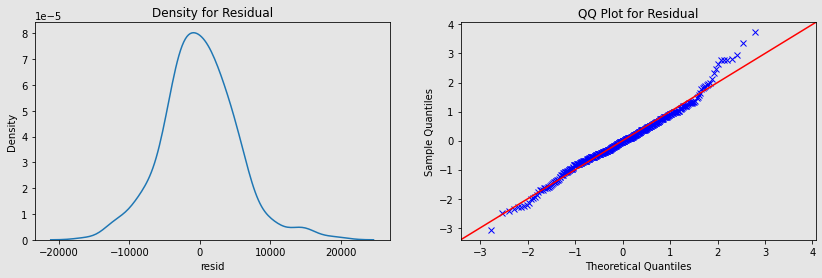

In [25]:
fig, axes = plt.subplots(1, 2, figsize = (14, 4), facecolor = "#e5e5e5")

for ax in axes: ax.set_facecolor("#e5e5e5")
    
sns.kdeplot(decompose.resid, ax = axes[0]).set_title("Density for Residual")

with warnings.catch_warnings(): 
    warnings.simplefilter("ignore")
    
    sm.qqplot(decompose.resid.dropna(), ax = axes[1], marker = "x", line = "45", fit = True)
    axes[1].set_title("QQ Plot for Residual")
    
plt.show()

As we can see kde plot and QQ plot, residual has normal distribution.

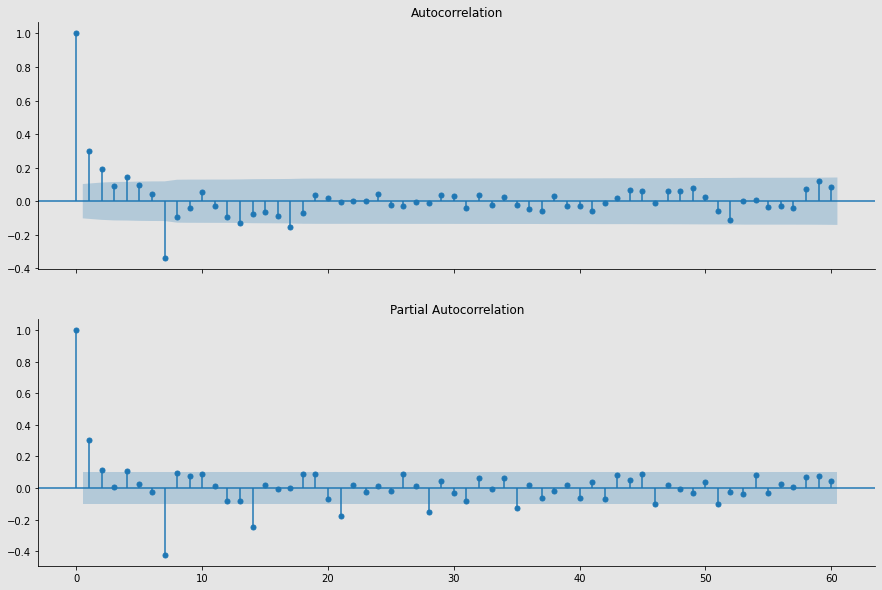

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 1, sharex = True, figsize = (15, 10), facecolor = "#e5e5e5")

for ax in axes: ax.set_facecolor("#e5e5e5")
    
plot_acf(daily_sales["TotalPrice"].diff(7).dropna(), lags = 60, ax = axes[0])
plot_pacf(daily_sales["TotalPrice"].diff(7).dropna(), lags = 60, ax = axes[1])

sns.despine()
plt.show()

# Modelling

I will use daily sales data for model training. We have 0 values on saturdays, it is fixed. We can get rid of these records with subsetting the data, just like stock prices. 

For training set, I just get first 85% records of all days, and remaining part is validation set.

First of all, I want to say again, my main goal is getting more detailed project about this dataset. As we talk theoretical part, I think this dataset is not fully convenient for forecasting. We have one year data and after then major peak, we don't have a lot observations to predicting the behaivor of data.

This part would be a simple introduction of Facebook's Prophet, and I probably prepare more detailed notebooks about these concepts.

In [27]:
daily_data = daily_sales[["TotalPrice"]].dropna().reset_index()

daily_data.columns = ["ds", "y"]

train_size = int(0.85 * len(daily_data))

train = daily_data.iloc[:train_size]
val = pd.DataFrame(daily_data.iloc[train_size:])

print(f"Training Days:\t\t{len(train)} \nValidation Days:\t {len(val)}")

Training Days:		317 
Validation Days:	 57


For this problem our metrics are R2, mean squared error and correlation. Actually, I don't like to use infinite intervaled metrics like MSE, but I just add it for variety.

In [28]:
def scores(y_true, y_pred):
    print(f"R2: {r2_score(y_true, y_pred)}")
    print(f"MSE: {mean_squared_error(y_true, y_pred)}")
    print(f"Correlation: {np.corrcoef(y_true, y_pred)[0][1]}")

# Simple Model

In [29]:
from fbprophet import Prophet

model = Prophet()

model.fit(train)

val_pred = model.predict(val)
train_pred = model.predict(train)

Initial log joint probability = -25.3527
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       455.182    0.00558287       57.5993      0.6397      0.6397      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       455.662   2.37641e-05       46.0565      0.7451      0.7451      269   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       455.663    1.6828e-05       54.1339   2.393e-07       0.001      357  LS failed, Hessian reset 
     233       455.663   4.63621e-08        51.472   2.255e-09       0.001      414  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [30]:
print("For Training set: \n")
scores(train.y, train_pred.yhat)

print("\nFor Validation set: \n")
scores(val.y, val_pred.yhat)

For Training set: 

R2: 0.536385347169019
MSE: 42908953.12706927
Correlation: 0.7325746218896569

For Validation set: 

R2: 0.48081615424916646
MSE: 93701059.22611764
Correlation: 0.8403436155474736


First model is simple prophet model with default parameters. We don't have good results, we have 53% R2 for training and 48% R2 for validation set.

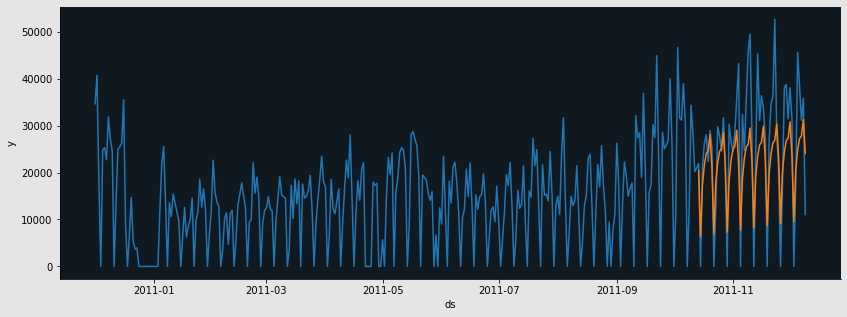

In [31]:
fig, ax = plt.subplots(figsize = (14, 5), facecolor = "#e5e5e5")
ax.set_facecolor("#101820")

sns.lineplot(x = daily_data.ds, y = daily_data.y, ax = ax)
sns.lineplot(x = val_pred.ds, y = val_pred.yhat, ax = ax)

sns.despine()
plt.show()

It seems, the model does not capture huge peaks.

Let's add some parameters.

# Prophet's parameters

We can add holidays to prophet model with below format.

I just add "Black Friday" as a holiday for three years.

In [32]:
black_friday = pd.DataFrame(
    {
        "holiday": "black friday",
        "ds": pd.to_datetime(["2011-11-24", "2012-11-23", "2013-11-22"]),
        "lower_window": 0,
        "upper_window": 1
    }
)

In saturdays, we don't have any sale record. I will simply add "is_saturday" column as an extra regressor.

In [33]:
def is_saturday(ds):
    date = pd.to_datetime(ds)
    return date.day_name() == "Saturday"

daily_data["is_saturday"] = daily_data["ds"].apply(is_saturday)

train = daily_data.iloc[:train_size]
val = pd.DataFrame(daily_data.iloc[train_size:])

Prophet gives lots of options in model building step.

holidays: You can use this for adding special days to model.

seasonality: If the data has seasonality, you can set daily_seasonality, weekly_seasonality, and yearly_seasonality parameters to True.


_prior_scale: This parameter controls the flexibility of components' affects. 


In this model, I just set them with simple numbers. You can turn them with [0.01-10] range.

Also you can use add_country_holidays(country) method for adding all holidays for a country.

In [34]:
model = Prophet(
    holidays = black_friday,
    daily_seasonality = True, 
    weekly_seasonality = True,
    holidays_prior_scale = 1,
    seasonality_prior_scale = 5,
    changepoint_prior_scale = 1,
)

model.add_country_holidays(country_name = "UK")

model.add_regressor("is_saturday")

model.fit(train)

val_pred = model.predict(val)
train_pred = model.predict(train)

Initial log joint probability = -25.3527
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        519.66     0.0164488       177.085      0.1496           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       527.269    0.00220525       22.5568     0.04936      0.7878      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       531.347     0.0117191       21.6749           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       533.838    0.00275006       25.4794      0.4446      0.4446      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     414       534.044   9.02441e-05       7.05822   6.803e-06       0.001      517  LS failed, Hessian reset 
     499       534.585   0.000321076    

In [35]:
print("For Training set: \n")
scores(train.y, train_pred.yhat)

print("\nFor Validation set: \n")
scores(val.y, val_pred.yhat)

For Training set: 

R2: 0.7255127700088215
MSE: 25404632.08777059
Correlation: 0.8518644127382715

For Validation set: 

R2: 0.4798551937456643
MSE: 93874491.08034338
Correlation: 0.8201204411352527


We get 48% R2 for validation. Let's plot that results.

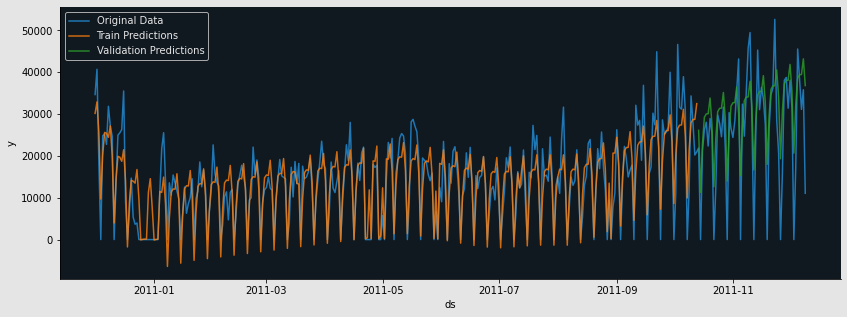

In [36]:
fig, ax = plt.subplots(figsize = (14, 5), facecolor = "#e5e5e5")
ax.set_facecolor("#101820")

sns.lineplot(x = daily_data.ds, y = daily_data.y, ax = ax, label = "Original Data")
sns.lineplot(x = train_pred.ds, y = train_pred.yhat, alpha = 0.8, ax = ax, label = "Train Predictions")
sns.lineplot(x = val_pred.ds, y = val_pred.yhat, ax = ax, alpha = 0.8, label = "Validation Predictions")

ax.legend(labelcolor = "#e5e5e5", facecolor = "#101820")
sns.despine()
plt.show()

We have a problem, we get negative valued forecasts. Actually, using "floor" and "cap" didn't work for me. http://facebook.github.io/prophet/docs/saturating_forecasts.html#saturating-minimum

To get rid of this, I will manually set them zero.

In [37]:
train_pred["yhat"] = np.where((train_pred.is_saturday == 0), train_pred.yhat, 0)
val_pred["yhat"] = np.where((val_pred.is_saturday == 0), val_pred.yhat, 0)

print("For Training set: \n")
scores(train.y, train_pred.yhat)

print("\nFor Validation set: \n")
scores(val.y, val_pred.yhat)

For Training set: 

R2: 0.7466945892204688
MSE: 23444189.978901386
Correlation: 0.8649717118530668

For Validation set: 

R2: 0.6854372643012339
MSE: 56771530.488229476
Correlation: 0.8513100295773223


68% R2 for validation set, good increasing.

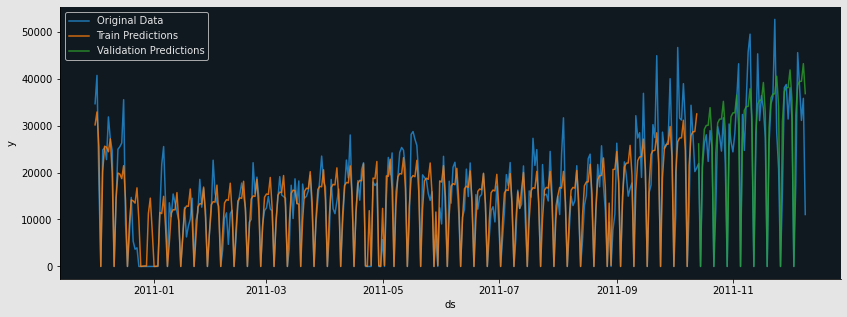

In [38]:
fig, ax = plt.subplots(figsize = (14, 5), facecolor = "#e5e5e5")
ax.set_facecolor("#101820")

sns.lineplot(x = daily_data.ds, y = daily_data.y, ax = ax, label = "Original Data")
sns.lineplot(x = train_pred.ds, y = train_pred.yhat, alpha = 0.8, ax = ax, label = "Train Predictions")
sns.lineplot(x = val_pred.ds, y = val_pred.yhat, ax = ax, alpha = 0.8, label = "Validation Predictions")

ax.legend(labelcolor = "#e5e5e5", facecolor = "#101820")
sns.despine()
plt.show()

Our model can not capture sudden trends well. Actually, we have to investigate the reasons underlying this peaks. Is it yearly seasonal, or not? We can not detect it since we have only one year data.

# Forecasting Future

Now, I will build a new model for forecasting next year. I just add yearly seasonality to last model that we used.

In [39]:
model = Prophet(
    holidays = black_friday,
    daily_seasonality = True, 
    weekly_seasonality = True,
    yearly_seasonality = True,
    holidays_prior_scale = 1,
    seasonality_prior_scale = 5,
    changepoint_prior_scale = 1,
)

model.add_country_holidays(country_name = "UK")

model.add_regressor("is_saturday")

model.fit(daily_data)

Initial log joint probability = -21.1738
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       670.195    0.00244696       10.9051      0.4369           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       670.403   0.000571958       8.40166      0.1868      0.1868      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       670.498    0.00027185       5.59027           1           1      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     376        670.51   5.34389e-05       6.59533   6.307e-06       0.001      512  LS failed, Hessian reset 
     399       670.516    5.7446e-05       5.37816       0.552       0.552      537   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     430       670.516   4.72468e-06    

In [40]:
future = model.make_future_dataframe(periods = 365)

future["is_saturday"] = future["ds"].apply(is_saturday)
future.tail()

,ds,is_saturday
734,2012-12-04,False
735,2012-12-05,False
736,2012-12-06,False
737,2012-12-07,False
738,2012-12-08,True


In [41]:
forecast = model.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
734,2012-12-04,33014.989027,25971.346450,40280.848616
735,2012-12-05,32565.093449,25229.184795,39776.930573
736,2012-12-06,35165.221198,27572.425281,42150.245303
737,2012-12-07,27290.037783,20031.076686,34318.494931
738,2012-12-08,9387.064502,2210.590147,16494.965496


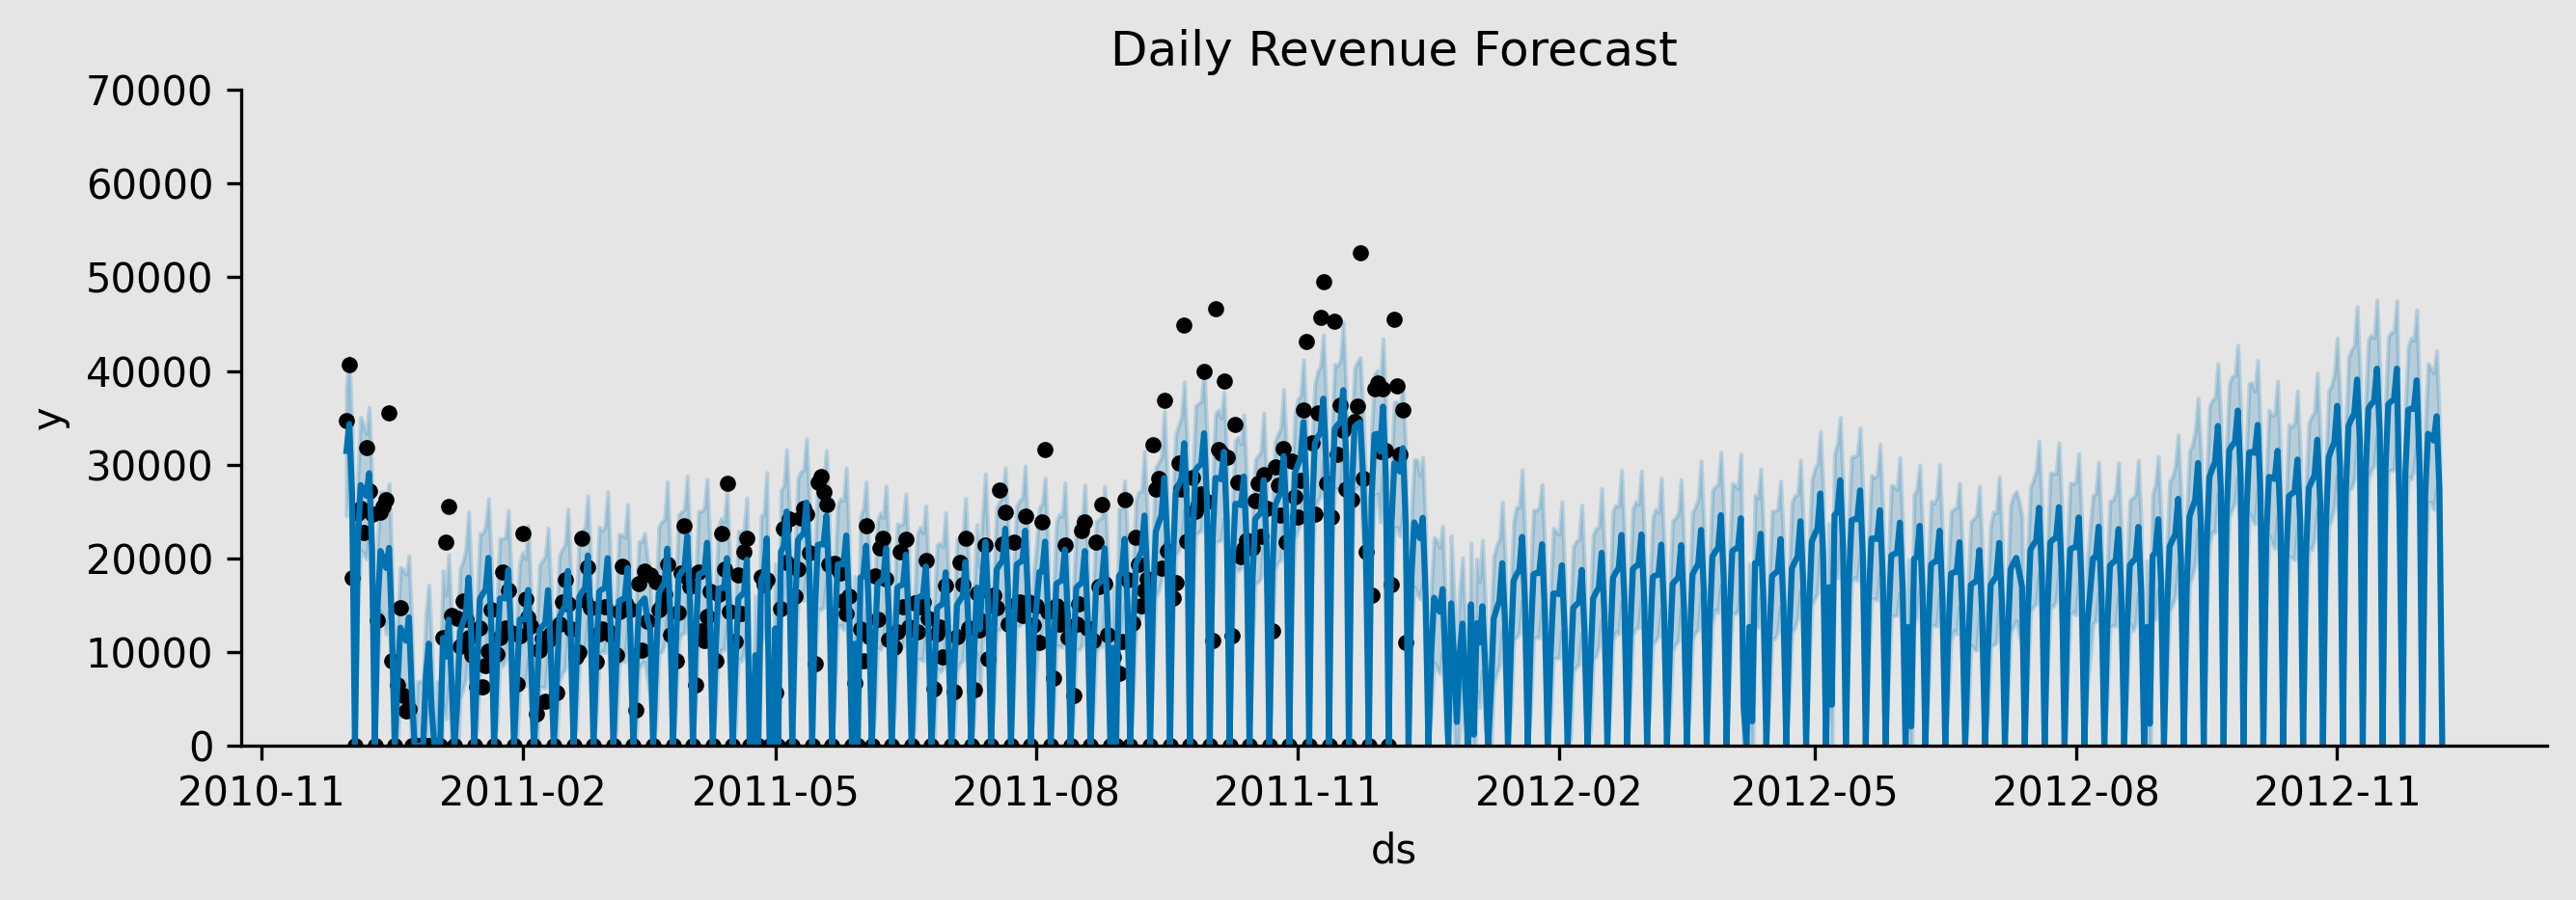

In [42]:
forecast["yhat"] = np.where((forecast.is_saturday == 0), forecast.yhat, 0)
forecast["yhat_lower"] = np.where((forecast.is_saturday == 0), forecast.yhat_lower, 0)
forecast["yhat_upper"] = np.where((forecast.is_saturday == 0), forecast.yhat_upper, 0)

fig, ax = plt.subplots(figsize = (9, 3), facecolor = "#e5e5e5", dpi = 300)

model.plot(forecast, ax = ax)

ax.set_title("Daily Revenue Forecast")
ax.grid(False)
ax.set_facecolor("#e5e5e5")
ax.set_ylim(0, 70000)

sns.despine()
plt.show()

Here is the results of this year's predictions and next year's forecast. Black dots represent actual revenue, and blue lines represent forecasts.

In the last months of the year, our predictions on the border of upper confidence interval, or sometimes outside of it. 

If we look at next year's forecast, we can see minor peaks in the middle of the year, and also we have positive trend late of the year.